In [4]:
import pandas as pd
import numpy as np
agora_data = pd.read_json('agora_hack_products.json')
agora_data

,product_id,name,props,is_reference,reference_id
0,0007302f2fe1d54d,Классическая сплит-система ROYAL CLIMA PANDORA...,"[Класс энергоэффективности\tA, Мощность конд...",False,f497219eb0077f84
1,000740b6c1cc763e,Смартфон Xiaomi Redmi Note 10S NFC 6/128 ГБ RU...,"[Экран\t6.43"" (2400x1080) AMOLED 60 Гц, 4 каме...",True,None
2,0039af5efceac4ab,Холодильник Бирюса 118,[Мощность замораживания 4 кг/сутки],False,28085e941cde1639
3,004f2158acb8165c,ASUS TUF-GTX1660S-O6G-GAMING Видеокарта,"[Объем видеопамяти\t6144 МБ, Частота памяти\...",False,9afe55bb4bf1e8a8
4,005cddb29e1677ec,"Кофемашина Saeco Lirika One Touch Cappuccino, ...","[Приготовление капучино\tавтоматическое, Мате...",False,1f21918ceb5d345c
...,...,...,...,...,...
3246,ff5da4be6fa60c4b,"15.6"" Ноутбук Lenovo IdeaPad Gaming 315IHU6 19...","[Видеокарта\tNVIDIA GeForce RTX 3050 4 ГБ, Вре...",True,None
3247,ff66532467a02652,Моющий робот-пылесос для дома и квартиры Xiaom...,"[Объем контейнера для воды\t0.27 л, ШхГхВ\t35....",False,d4ebc4a26700d5e0
3248,ff75ade409f4da7e,"Huawei Умный браслет Band 7, графитово-черный","[Модификация\tGPS, Материал корпуса\tпластик]",False,177ccb3b84125efa
3249,ffb770de0c2feafc,Видеокарта Gigabyte GV-R675XTGAMING OC-12GD 12...,[Комплектация\tRetail],False,a07d5538ebec8e36


## деление датасета на эталоны и товары

In [5]:
agora_data_goods = agora_data[agora_data['is_reference'] == False]
agora_data_prime = agora_data[agora_data['is_reference'] == True]

## сколько товаров относится к разным эталонам

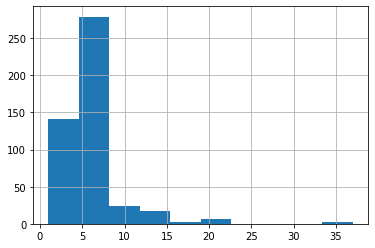

In [6]:
agora_data_goods['reference_id'].value_counts().hist()

In [11]:
X = []
y = []
for index, row in agora_data_goods.iterrows():
    tmp = row['name'] + ' ' + ' '.join(row['props']).replace("\t", " ")
    X.append(tmp)
    y.append(row.reference_id)
X = np.array(X)
y = np.array(y)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## векторизуем фичи

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
scaler = TfidfVectorizer()
scaler.fit(X_train)
X_train_vec = scaler.transform(X_train)
X_test_vec = scaler.transform(X_test)

## к ближайших соседей

In [13]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score

neigh = neighbors.KNeighborsClassifier(n_neighbors=5, metric='cosine')
neigh.fit(X_train_vec, y_train)
ans = neigh.predict(X_test_vec)

accuracy_score(y_test, ans)

NameError: ignored

## дефолтный случайный лес

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier()
forest.fit(X_train_vec, y_train)
ans = forest.predict(X_test_vec)

accuracy_score(y_test, ans)

0.8453237410071942

## подбор параметров леса

In [32]:
from sklearn.model_selection import RandomizedSearchCV
forest = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(forest,
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_vec, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 800,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'bootstrap': False}

In [33]:
est = rs.best_estimator_
est.fit(X_train_vec, y_train)
ans = est.predict(X_test_vec)

accuracy_score(y_test, ans)

0.8219424460431655

# ОБУЧЕНИЕ ТОЛЬКО НА ИМЕНАХ

In [7]:
X2 = []
y2 = []
for index, row in agora_data_goods.iterrows():
    tmp = row['name']
    X2.append(tmp)
    y2.append(row.reference_id)
X2 = np.array(X2)
y2 = np.array(y2)

In [8]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
scaler = TfidfVectorizer()
scaler.fit(X_train2)
X_train_vec2 = scaler.transform(X_train2)
X_test_vec2 = scaler.transform(X_test2)

In [10]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score

neigh = neighbors.KNeighborsClassifier(n_neighbors=5, metric='cosine')
neigh.fit(X_train_vec2, y_train2)
ans = neigh.predict(X_test_vec2)

accuracy_score(y_test2, ans)

0.7949640287769785

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(n_estimators=700)
forest.fit(X_train_vec2, y_train2)
ans = forest.predict(X_test_vec2)

accuracy_score(y_test2, ans)

0.8866906474820144

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

forest = ExtraTreesClassifier()
forest.fit(X_train_vec2, y_train2)
ans = forest.predict(X_test_vec2)

accuracy_score(y_test2, ans)

0.89568345323741